In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from scipy.stats import describe
from statistics import mean
from statistics import stdev
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

In [2]:
# Imports
buttermilks_df = pd.read_csv("data/transform-data/buttermilks-transform.csv")
druid_stones_df = pd.read_csv("data/transform-data/druid_stones-transform.csv")
happy_boulders_df = pd.read_csv("data/transform-data/happy_boulders-transform.csv")
sad_boulders_df = pd.read_csv("data/transform-data/sad_boulders-transform.csv")

In [3]:
# Concatenate and format
bishop_df = buttermilks_df.append(druid_stones_df).append(happy_boulders_df).append(sad_boulders_df)
data_df = bishop_df.dropna().reset_index(drop=True)
data_df = data_df.rename(columns = {'log_star_ratings':'Log StarRatings',
                                    'log_ticks':'Log Ticks',
                                    'avg_stars':'Avg Stars',
                                    'log_length':'Log Length',
                                    'grade':'Grade',
                                    'log_on_to_do_lists':'Log OnToDoLists',
                                    'sqrt_star_ratings':'Sqrt StarRatings',
                                    'sqrt_ticks':'Sqrt Ticks',
                                    'sqrt_avg_stars': 'Sqrt Avg Stars',
                                    'sqrt_length': 'Sqrt Length',
                                    'sqrt_grade': 'Sqrt Grade',
                                    'on_to_do_lists': 'OnToDoLists'})
data_df.head()

,route,location,url,Avg Stars,your_stars,route_type,rating,pitches,length_,area_latitude,...,Log Ticks,log_avg_stars,Log Length,log_grade,Log OnToDoLists,Sqrt StarRatings,Sqrt Ticks,Sqrt Avg Stars,Sqrt Length,Sqrt Grade
0,The Way Down,Birthday Boulders > Buttermilks Main > Butterm...,https://www.mountainproject.com/route/10627753...,1.3,-1,Boulder,V-easy,1,10.0,37.33004,...,1.724276,0.361728,1.041393,0.000000,0.954243,5.477226,7.211103,1.140175,3.162278,0.000000
1,Choke the Chicken,Chicken Head Boulder > Zeppelin Area > Dale's ...,https://www.mountainproject.com/route/11671544...,2.0,-1,Boulder,V-easy,1,15.0,37.31826,...,0.301030,0.477121,1.204120,0.000000,0.000000,1.000000,1.000000,1.414214,3.872983,0.000000
2,Unnamed 1,Sunshine Boulder > Buttermilks Main > Buttermi...,https://www.mountainproject.com/route/10703277...,2.2,-1,Boulder,V0-,1,18.0,37.32859,...,1.944483,0.505150,1.278754,0.243038,1.079181,6.403124,9.327379,1.483240,4.242641,0.866025
3,Unnamed 2,Sunshine Boulder > Buttermilks Main > Buttermi...,https://www.mountainproject.com/route/10703278...,2.8,-1,Boulder,V0-,1,18.0,37.32859,...,2.227887,0.579784,1.278754,0.243038,1.698970,9.165151,12.961481,1.673320,4.242641,0.866025
4,Problem B,Green Wall Boulder > Buttermilks Main > Butter...,https://www.mountainproject.com/route/10632257...,1.8,-1,Boulder,V0-,1,12.0,37.32873,...,2.012837,0.447158,1.113943,0.243038,1.113943,6.782330,10.099505,1.341641,3.464102,0.866025


In [4]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

In [5]:
# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(data_df.drop(columns = ['Log OnToDoLists']), data_df['Log OnToDoLists'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Log StarRatings', 'Log Ticks', 'Avg Stars', 'Log Length', 'Grade',                
                 'Sqrt StarRatings', 'Sqrt Ticks', 'Sqrt Avg Stars', 'Sqrt Length', 'Sqrt Grade']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

In [6]:
# Grid searching

r2_cv_full_mean_list, r2_test_list = [], []

for i in range(101):

    # KFold Cross-Validation
    r2_cv_list = [] # Collect the cross-validation results

    for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

        # Make the split
        features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
        features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 

        # Standard Scaler
        features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
        features_val_cv_scaled_array = scaler.transform(features_val_cv_array)

        # Fit OLS
        ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_scaled_array[:,0:5]))
        ols_results = ols_model.fit() # Fit model

        features_train_cv_scaled_df = pd.DataFrame(features_train_cv_scaled_array[:,5:10]).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
        features_train_cv_scaled_df['OnToDoLists'] = 10**target_train_cv_array-1
        features_val_cv_scaled_df = pd.DataFrame(features_val_cv_scaled_array[:,5:10]).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
        features_val_cv_scaled_df['OnToDoLists'] = 10**target_val_cv_array-1

        # Fit Poisson
        poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_cv_scaled_df, family=sm.families.Poisson())
        poisson_glm_results = poisson_glm_model.fit()

        # Ensemble Model
        ensemble_array = 0.01*i*(10**ols_results.predict(sm.add_constant(features_val_cv_scaled_array[:,0:5]))-1) + (1-0.01*i)*poisson_glm_results.predict(features_val_cv_scaled_df)

        # Collect results on the validation set
        SSE = sum((10**target_val_cv_array-1 - ensemble_array)**2)
        SST = sum((10**target_val_cv_array-1 - np.mean(10**target_val_cv_array-1))**2)
        r2_cv_list.append(1-SSE/SST)

    #print(r2_cv_list)
    #print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))
    r2_cv_full_mean_list.append(mean(r2_cv_list))

    # Test
    features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
    features_test_scaled_array = scaler.transform(features_test_chosen_df)

    # Fit OLS
    ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_scaled_array[:,0:5]))
    ols_results = ols_model.fit()

    # Fit Poisson
    features_train_scaled_df = pd.DataFrame(features_train_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_train_scaled_df['OnToDoLists'] = 10**target_train_array-1
    features_test_scaled_df = pd.DataFrame(features_test_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_test_scaled_df['OnToDoLists'] = 10**target_test_array-1

    poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_scaled_df, family=sm.families.Poisson())
    poisson_glm_results = poisson_glm_model.fit()

    # Ensemble Model
    ensemble_array = 0.01*i*(10**ols_results.predict(sm.add_constant(features_test_scaled_array[:,0:5]))-1) + (1-0.01*i)*poisson_glm_results.predict(features_test_scaled_df)

    # Collect results on the test set
    SSE = sum((10**target_test_array-1 - ensemble_array)**2)
    SST = sum((10**target_test_array-1 - np.mean(10**target_test_array-1))**2)

    #print('test_r2_score: ', 1-SSE/SST) #Get score
    r2_test_list.append(1-SSE/SST)

In [8]:
r2_cv_full_mean_list.index(max(r2_cv_full_mean_list))

76

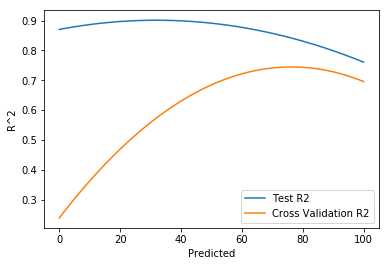

In [7]:
ax = plt.plot(list(range(101)), r2_test_list, label= "Test R2")
ax = plt.plot(list(range(101)), r2_cv_full_mean_list, label= "Cross Validation R2")
plt.xlabel('Predicted')
plt.ylabel('R^2')
plt.legend()
plt.savefig("figures/bishop/ensemble/ratio-optimization.png", transparent=True, bbox_inches="tight")
plt.show()

In [8]:
# Ensembling

i = 76

# KFold Cross-Validation
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 

    # Standard Scaler
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)

    # Fit OLS
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_scaled_array[:,0:5]))
    ols_results = ols_model.fit() # Fit model

    features_train_cv_scaled_df = pd.DataFrame(features_train_cv_scaled_array[:,5:10]).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_train_cv_scaled_df['OnToDoLists'] = 10**target_train_cv_array-1
    features_val_cv_scaled_df = pd.DataFrame(features_val_cv_scaled_array[:,5:10]).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_val_cv_scaled_df['OnToDoLists'] = 10**target_val_cv_array-1

    # Fit Poisson
    poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_cv_scaled_df, family=sm.families.Poisson())
    poisson_glm_results = poisson_glm_model.fit()

    # Ensemble Model
    ensemble_array = 0.01*i*(10**ols_results.predict(sm.add_constant(features_val_cv_scaled_array[:,0:5]))-1) + (1-0.01*i)*poisson_glm_results.predict(features_val_cv_scaled_df)

    # Collect results on the validation set
    SSE = sum((10**target_val_cv_array-1 - ensemble_array)**2)
    SST = sum((10**target_val_cv_array-1 - np.mean(10**target_val_cv_array-1))**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit OLS
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_scaled_array[:,0:5]))
ols_results = ols_model.fit()

# Fit Poisson
features_train_scaled_df = pd.DataFrame(features_train_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
features_train_scaled_df['OnToDoLists'] = 10**target_train_array-1
features_test_scaled_df = pd.DataFrame(features_test_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
features_test_scaled_df['OnToDoLists'] = 10**target_test_array-1

poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_scaled_df, family=sm.families.Poisson())
poisson_glm_results = poisson_glm_model.fit()

# Ensemble Model
ensemble_array = 0.01*i*(10**ols_results.predict(sm.add_constant(features_test_scaled_array[:,0:5]))-1) + (1-0.01*i)*poisson_glm_results.predict(features_test_scaled_df)

# Collect results on the test set
SSE = sum((10**target_test_array-1 - ensemble_array)**2)
SST = sum((10**target_test_array-1 - np.mean(10**target_test_array-1))**2)

print('test_r2_score: ', 1-SSE/SST) #Get score

[0.839880464058299, 0.6920451840560217, 0.638081955566163, 0.7487480028955672, 0.8031225349404194]
val_r2_score:  0.7443756283032941  +/-  0.08159091648379424
test_r2_score:  0.8420211467188347


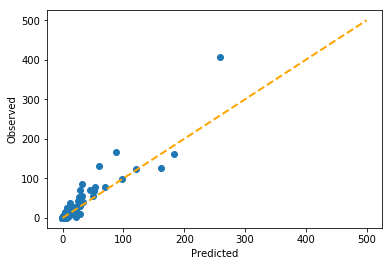

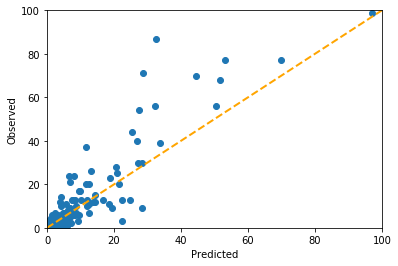

DescribeResult(nobs=202, minmax=(0.0, 2.611723308007342), mean=0.6825642231784663, variance=0.33903558879140744, skewness=0.865569514980544, kurtosis=0.1984873993830658)


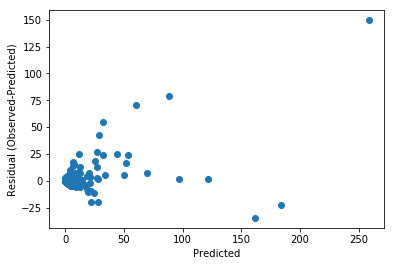

<Figure size 576x360 with 0 Axes>

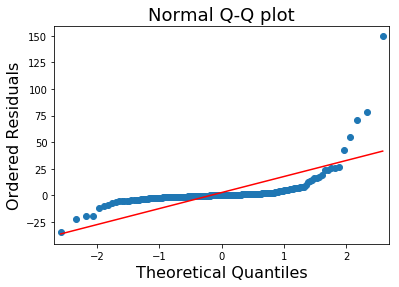

DescribeResult(nobs=202, minmax=(-34.48396667169287, 149.4637776117949), mean=2.749810061520834, variance=227.94379270128826, skewness=5.9095241774805265, kurtosis=48.20971384582934)


In [9]:
ax = plt.scatter(ensemble_array, 10**target_test_array-1)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.savefig("figures/bishop/ensemble/predicted-vs-observed.png", transparent=True, bbox_inches="tight")
plt.show()

ax = plt.scatter(ensemble_array, 10**target_test_array-1)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Predicted')
plt.xlim(0, 100)
plt.ylabel('Observed')
plt.ylim(0, 100)
plt.savefig("figures/bishop/ensemble/predicted-vs-observed-zoomed-in.png", transparent=True, bbox_inches="tight")
plt.show()

print(describe(target_test_array))

X = ensemble_array
y = 10**target_test_array-1
ax = plt.scatter(X, y-X)
plt.xlabel('Predicted')
plt.ylabel('Residual (Observed-Predicted)')
plt.savefig("figures/bishop/ensemble/predicted-vs-residual.png", transparent=True, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 5))
res = y-X # residuals
fig = sm.qqplot(res, line='s', color = '#1f77b4')
plt.title("Normal Q-Q plot", fontsize=18)
plt.xlabel("Theoretical Quantiles", fontsize=16)
plt.ylabel("Ordered Residuals", fontsize=16)
plt.savefig("figures/bishop/ensemble/normal-qq-plot.png", transparent=True, bbox_inches="tight")
plt.show()

print(describe(y-X))

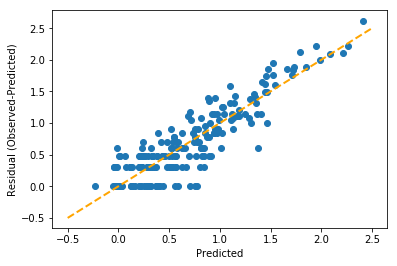

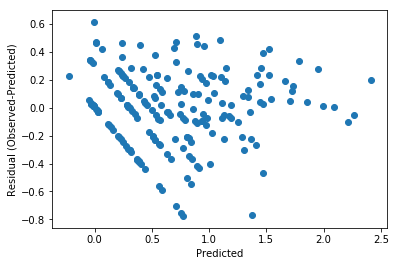

DescribeResult(nobs=202, minmax=(-0.7753202189160847, 0.6111749755690116), mean=0.00401462651318861, variance=0.06846155535639026, skewness=-0.45120898202673815, kurtosis=0.2657188708062659)


<Figure size 576x360 with 0 Axes>

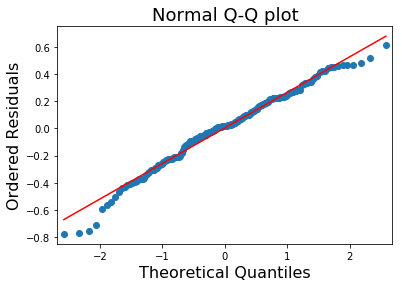

In [11]:

X = np.log(ensemble_array+1)/math.log(10)
y = target_test_array
ax = plt.scatter(X, y)
plt.plot([-0.5, 2.5], [-0.5, 2.5], c='orange', lw = 2, ls='--', label= "Equal")
plt.xlabel('Predicted')
plt.ylabel('Residual (Observed-Predicted)')
plt.savefig("figures/bishop/ensemble/log-predicted-vs-log-observed.png", transparent=True, bbox_inches="tight")
plt.show()

X = np.log(ensemble_array+1)/math.log(10)
y = target_test_array
ax = plt.scatter(X, y-X)
plt.xlabel('Predicted')
plt.ylabel('Residual (Observed-Predicted)')
plt.savefig("figures/bishop/ensemble/log-predicted-vs-residual.png", transparent=True, bbox_inches="tight")
plt.show()

print(describe(y-X))

plt.figure(figsize=(8, 5))
X = np.log(ensemble_array+1)/math.log(10)
y = target_test_array
res = y-X # residuals
fig = sm.qqplot(res, line='s', color = '#1f77b4')
plt.title("Normal Q-Q plot", fontsize=18)
plt.xlabel("Theoretical Quantiles", fontsize=16)
plt.ylabel("Ordered Residuals", fontsize=16)
plt.savefig("figures/bishop/ensemble/log-qq-plot.png", transparent=True, bbox_inches="tight")
plt.show()